# Understanding Transformers 

In this notebook, we will use Andrej Karpathy's excellent nanoGPT, to understand how transformers learn and generate output.

Let's go through the code step by step to understand how each function fits into the broader transformer architecture.

### Layer Normalization 

Layer Normalization speeds up training time by computing 
the mean and variance used for normalization from all of the summed inputs to the 
neurons in a layer on a single case. This implementation optionally supports bias.


In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import inspect
from dataclasses import dataclass
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)


PyTorch version: 2.8.0+cu128
Device: CPU


### Causal Self-Attention

The heart of the transformer, this is a multi-head, self-attention mechanism with causal masking.
* Causal masking means tokens can only attend to previous positions (so the model does not look ahead).
* Multi-head: splits attention into multiple heads that can focus on different aspects
* Flash attention is an optimized attention implementation requiring PyTorch 2.0
* Efficient batching: computes Queries, Keys and Values for all heads in one matrix operation

This attention mechanism allows the model to check previous tokens to understand context.


In [2]:
class CausalSelfAttention(nn.Module):
    """
    Multi-head causal self-attention.
    This is the core of the transformer - it allows the model to attend to previous tokens.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        
        # Use Flash Attention if available (PyTorch 2.0+)
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))


    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

### Multi-Layer Perceptron

A standard feed-forward neural network with two layers providing non-linear GELU activations between attention layers.

In [3]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron (Feed-Forward Network)
    This provides non-linearity and processing power between attention layers.
    """

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

### Block

Here is our Transformer building block class. Each block comprises:
* LayerNorm -> Attention -> Residual connection
* LayerNorm -> MLP -> Residual connection
The layernorm and residual connections help with value stability during training.
A residual connection simply means adding the input of a layer to its output eg
`x = x + layer(x)`


In [4]:
class Block(nn.Module):
    """
    Transformer Block: Attention + MLP with residual connections and layer normalization.
    This is the fundamental building block that gets stacked to create the full model.
    """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))  # Residual connection around attention
        x = x + self.mlp(self.ln_2(x))   # Residual connection around MLP
        return x

### GPTConfig

A dataclass that centralizes all hyperparameters, making it easy to experiment with different model configurations.

In [5]:
@dataclass
class GPTConfig:
    """Configuration class for GPT model hyperparameters"""
    block_size: int = 1024      # Maximum sequence length
    vocab_size: int = 50304     # Number of tokens in vocabulary  
    n_layer: int = 12           # Number of transformer blocks
    n_head: int = 12            # Number of attention heads
    n_embd: int = 768           # Embedding dimension
    dropout: float = 0.0        # Dropout probability
    bias: bool = True           # Whether to use bias in linear layers

### The complete GPT

Everything together:
* Token and position embeddings
* Transformer blocks
* Output projection mapping final hidden states back to vocabulary logits

#### Notable design choices

* Weight tying: token embeddings and output projections share weights - this is a common optimization
* Flexible forward pass: model can compute loss during training or just logits during inference

#### Modes
Here's what happens in training mode:
* We process the entire sequences in parallel
* Compute cross-entropy loss accross all positions
* Use ground truth tokens vs model predictions

And in inference mode:
* We just compute logits for the last token
* `generate()` enables autoregressive sampling

#### So how do we actually 'generate'?

Using the `generate()` method, we:
* Take current sequence
* Get logits for next token
* Apply temperature scaling and optional k-filtering
* Sample from the probability distribution
* Append to sequence and repeat

In [6]:
class GPT(nn.Module):
    """
    The complete GPT model.
    """

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),    # Token embeddings
            wpe = nn.Embedding(config.block_size, config.n_embd),    # Position embeddings
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),  # Transformer blocks
            ln_f = LayerNorm(config.n_embd, bias=config.bias),       # Final layer norm
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)  # Output projection
        
        # Weight tying: share weights between token embeddings and output projection
        self.transformer.wte.weight = self.lm_head.weight

        # Initialize all weights
        self.apply(self._init_weights)
        # Apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # Report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """Return the number of parameters in the model."""
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        # Forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # Training mode: calculate loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # Inference mode: only compute logits for the last token
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate new tokens autoregressively.
        """
        for _ in range(max_new_tokens):
            # Crop context if it's too long
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # Forward pass
            logits, _ = self(idx_cond)
            # Apply temperature
            logits = logits[:, -1, :] / temperature
            # Optionally crop to top-k
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # Convert to probabilities and sample
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            # Append to sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

print("✅ Model architecture defined!")

#### This is the end of Karpathy's code at https://github.com/karpathy/nanoGPT/blob/master/model.py

✅ Model architecture defined!


Here's the end of Karpathy's code. So the architecture flow looks like this:

Input tokens → Token + Position embeddings → Transformer blocks → Layer norm → Output projection → Logits

and each Transformer block is doing:

`x = x + attention(layernorm(x)) then x = x + mlp(layernorm(x))`

Let's see the model in action with some sample data

In [7]:
class SimpleTokenizer:
    """
    A simple character-level tokenizer.
    Converts text to integers and back.
    """
    def __init__(self, text):
        self.chars = sorted(list(set(text)))
        self.vocab_size = len(self.chars)
        self.stoi = {ch: i for i, ch in enumerate(self.chars)}  # string to int
        self.itos = {i: ch for i, ch in enumerate(self.chars)}  # int to string
    
    def encode(self, text):
        return [self.stoi[ch] for ch in text]
    
    def decode(self, tokens):
        return ''.join([self.itos[i] for i in tokens])

In [8]:
def create_educational_dataset():
    """
    Create a simple dataset that has clear patterns.
    We'll use counting numbers so it's easy to see if the model learns.
    """
    text = ""
    
    # Simple counting pattern
    for i in range(50):
        text += f"Number {i} comes before {i+1}. "
    
    # Add some simple sequences
    for i in range(20):
        text += f"A{i}B{i}C{i}. "
    
    return text

In [9]:
# Create our dataset
dataset_text = create_educational_dataset()
print(f"Dataset length: {len(dataset_text)} characters")
print(f"\nFirst 200 characters:")
print(repr(dataset_text[:200]))

# Create tokenizer
tokenizer = SimpleTokenizer(dataset_text)
print(f"\nVocabulary size: {tokenizer.vocab_size}")
print(f"Characters in vocabulary: {repr(''.join(tokenizer.chars))}")

# Test encoding/decoding
test_text = "Number 5"
encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)
print(f"\nTokenizer test:")
print(f"Original: {repr(test_text)}")
print(f"Encoded:  {encoded}")
print(f"Decoded:  {repr(decoded)}")

# Create a small model configuration for educational purposes
config = GPTConfig(
    block_size=64,              # Small context window
    vocab_size=tokenizer.vocab_size,
    n_layer=6,                  # 6 transformer blocks
    n_head=6,                   # 6 attention heads
    n_embd=192,                 # Small embedding dimension
    dropout=0.1,                # Some dropout for regularization
    bias=False                  # No bias for simplicity
)

print("Model Configuration:")
print(f"  Block size (context length): {config.block_size}")
print(f"  Vocabulary size: {config.vocab_size}")
print(f"  Number of layers: {config.n_layer}")
print(f"  Number of attention heads: {config.n_head}")
print(f"  Embedding dimension: {config.n_embd}")
print(f"  Dropout: {config.dropout}")

Dataset length: 1521 characters

First 200 characters:
'Number 0 comes before 1. Number 1 comes before 2. Number 2 comes before 3. Number 3 comes before 4. Number 4 comes before 5. Number 5 comes before 6. Number 6 comes before 7. Number 7 comes before 8. '

Vocabulary size: 25
Characters in vocabulary: ' .0123456789ABCNbcefmorsu'

Tokenizer test:
Original: 'Number 5'
Encoded:  [15, 24, 20, 16, 18, 22, 0, 7]
Decoded:  'Number 5'
Model Configuration:
  Block size (context length): 64
  Vocabulary size: 25
  Number of layers: 6
  Number of attention heads: 6
  Embedding dimension: 192
  Dropout: 0.1


In [10]:
# Create the model
model = GPT(config)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"\nModel created and moved to {device}")

number of parameters: 2.66M

Model created and moved to cpu


In [11]:
def test_generation(model, tokenizer, prompt, max_tokens=50, temperature=1.0):
    """Test text generation with the model"""
    model.eval()
    
    # Encode the prompt
    context = torch.tensor(tokenizer.encode(prompt), dtype=torch.long, device=device).unsqueeze(0)
    
    # Generate
    with torch.no_grad():
        generated = model.generate(context, max_new_tokens=max_tokens, temperature=temperature)
        result = tokenizer.decode(generated[0].tolist())
    
    return result

print("Testing model before training")

test_prompts = [
    "Number ",
    "A1B1",
    "comes before"
]

for prompt in test_prompts:
    result = test_generation(model, tokenizer, prompt, max_tokens=30, temperature=1.0)
    print(f"Prompt: {repr(prompt)}")
    print(f"Generated: {repr(result)}")
    print(f"New text: {repr(result[len(prompt):])}")
    print()


Testing model before training
Prompt: 'Number '
Generated: 'Number 135.9N  sBBC9b89ooB11.BAc6c 6 '
New text: '135.9N  sBBC9b89ooB11.BAc6c 6 '

Prompt: 'A1B1'
Generated: 'A1B1737 274.A08N5B9eN AB0A2A4moC0N'
New text: '737 274.A08N5B9eN AB0A2A4moC0N'

Prompt: 'comes before'
Generated: 'comes before922fre5AuCC5A 55oc88m Nb5.274o'
New text: '922fre5AuCC5A 55oc88m Nb5.274o'



As expected, the untrained model produces mostly gibbersish.

Let's create some training data and try a short training cycle.


In [12]:
def prepare_training_data(text, tokenizer, block_size):
    """Convert text to training data format"""
    # Encode the entire text
    data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
    
    # Split into train/validation
    n = len(data)
    train_data = data[:int(n*0.9)]
    val_data = data[int(n*0.9):]
    
    return train_data, val_data

def get_batch(data, block_size, batch_size, device):
    """Get a batch of training data"""
    # Random starting positions
    ix = torch.randint(len(data) - block_size, (batch_size,))
    
    # Create input and target sequences
    x = torch.stack([data[i:i+block_size] for i in ix]).to(device)
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]).to(device)
    
    return x, y

# Prepare the data
train_data, val_data = prepare_training_data(dataset_text, tokenizer, config.block_size)

print(f"Training data: {len(train_data)} tokens")
print(f"Validation data: {len(val_data)} tokens")

# Test batch creation
batch_size = 4
x, y = get_batch(train_data, config.block_size, batch_size, device)

print(f"\nBatch shapes:")
print(f"Input (x): {x.shape}")
print(f"Target (y): {y.shape}")

print(f"\nExample training pair:")
print(f"Input:  {repr(tokenizer.decode(x[0].tolist()))}")
print(f"Target: {repr(tokenizer.decode(y[0].tolist()))}")

Training data: 1368 tokens
Validation data: 153 tokens

Batch shapes:
Input (x): torch.Size([4, 64])
Target (y): torch.Size([4, 64])

Example training pair:
Input:  'mes before 21. Number 21 comes before 22. Number 22 comes before'
Target: 'es before 21. Number 21 comes before 22. Number 22 comes before '


In [13]:
def train_model(model, train_data, val_data, config, num_steps=500):
    """Train the model and track progress"""
    
    # Training hyperparameters
    learning_rate = 3e-4
    batch_size = 8
    eval_interval = 50
    
    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # Track losses
    train_losses = []
    val_losses = []
    steps = []
    
    print("Starting Training!")
    
    for step in range(num_steps):
        # Training step
        model.train()
        x, y = get_batch(train_data, config.block_size, batch_size, device)
        
        logits, loss = model(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluation
        if step % eval_interval == 0 or step == num_steps - 1:
            model.eval()
            with torch.no_grad():
                # Validate
                val_x, val_y = get_batch(val_data, config.block_size, batch_size, device)
                val_logits, val_loss = model(val_x, val_y)
            
            train_losses.append(loss.item())
            val_losses.append(val_loss.item())
            steps.append(step)
            
            print(f"Step {step:4d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")
    
    return train_losses, val_losses, steps

# Train the model
train_losses, val_losses, steps = train_model(model, train_data, val_data, config, num_steps=300)

print("\nTraining completed!")


Starting Training!
Step    0 | Train Loss: 3.3133 | Val Loss: 3.4997
Step   50 | Train Loss: 0.8711 | Val Loss: 3.0150
Step  100 | Train Loss: 0.5653 | Val Loss: 3.6264
Step  150 | Train Loss: 0.4027 | Val Loss: 3.5177
Step  200 | Train Loss: 0.3507 | Val Loss: 2.8375
Step  250 | Train Loss: 0.3582 | Val Loss: 3.6985
Step  299 | Train Loss: 0.3506 | Val Loss: 3.5403

Training completed!


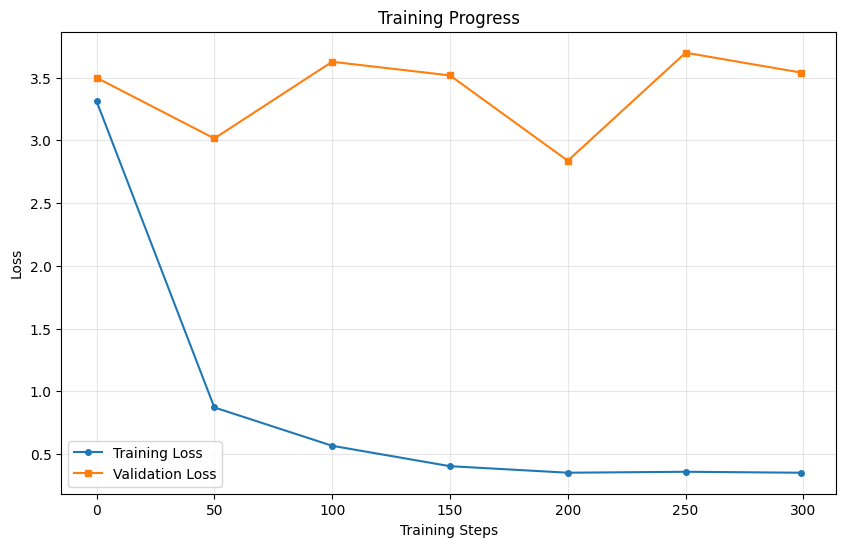

Final training loss: 0.3506
Final validation loss: 3.5403


In [14]:
# Plot the training progress
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Training Loss', marker='o', markersize=4)
plt.plot(steps, val_losses, label='Validation Loss', marker='s', markersize=4)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")

In [15]:
print("Testing model after training")

# Test with the same prompts as before
test_prompts = [
    "Number ",
    "A1B1",
    "comes before"
]

for prompt in test_prompts:
    result = test_generation(model, tokenizer, prompt, max_tokens=30, temperature=0.8)
    print(f"Prompt: {repr(prompt)}")
    print(f"Generated: {repr(result)}")
    print(f"New text: {repr(result[len(prompt):])}")
    print()

print("Compare this to the pre-training gibberish!")
print("\nLet's also try some longer generations:")

# Longer generations
longer_prompts = [
    "Number 5 comes",
    "A10B10"
]

for prompt in longer_prompts:
    result = test_generation(model, tokenizer, prompt, max_tokens=60, temperature=0.7)
    print(f"Prompt: {repr(prompt)}")
    print(f"Generated: {repr(result)}")
    print()



Testing model after training
Prompt: 'Number '
Generated: 'Number 28 comes before 36. Number 18 '
New text: '28 comes before 36. Number 18 '

Prompt: 'A1B1'
Generated: 'A1B1. Number 23 comes before 4. Nu'
New text: '. Number 23 comes before 4. Nu'

Prompt: 'comes before'
Generated: 'comes before 23. Number 23 comes before 4.'
New text: ' 23. Number 23 comes before 4.'

Compare this to the pre-training gibberish!

Let's also try some longer generations:
Prompt: 'Number 5 comes'
Generated: 'Number 5 comes before 7. Number 5 comes before 8. Number 8 comes before 8.'

Prompt: 'A10B10'
Generated: 'A10B10. Number 42 comes before 28. Number 24 comes before 44. Numb'



In [16]:
print("Model analysis")

# Test different temperatures
print("Testing different temperatures:")
prompt = "Number 3"

temperatures = [0.1, 0.5, 1.0, 1.5]
for temp in temperatures:
    result = test_generation(model, tokenizer, prompt, max_tokens=25, temperature=temp)
    print(f"Temperature {temp}: {repr(result[len(prompt):])}")

print("\n" + "-" * 50)

# Test model's understanding of patterns
print("Testing pattern completion:")
test_cases = [
    "Number 15 comes before",
    "A5B5",
    "before 7"
]

for case in test_cases:
    result = test_generation(model, tokenizer, case, max_tokens=20, temperature=0.5)
    print(f"Input: {repr(case)}")
    print(f"Completion: {repr(result[len(case):])}")
    print()

# Show model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB (fp32)")



Model analysis
Testing different temperatures:
Temperature 0.1: '8 comes before 37. Number'
Temperature 0.5: '6 comes before 38. Number'
Temperature 1.0: '6 comes before 44. Number'
Temperature 1.5: '7 co1. Numbeber36 comes b'

--------------------------------------------------
Testing pattern completion:
Input: 'Number 15 comes before'
Completion: ' 38. Number 26 comes'

Input: 'A5B5'
Completion: '. Number 19 comes be'

Input: 'before 7'
Completion: '. Number 17 comes be'

Total parameters: 2,673,792
Trainable parameters: 2,673,792
Model size: ~10.2 MB (fp32)


In [17]:
print("What did the model learn?")

# Test if it learned the counting pattern
print("1. Counting pattern recognition:")
for i in [7, 12, 25]:
    prompt = f"Number {i} comes before"
    result = test_generation(model, tokenizer, prompt, max_tokens=10, temperature=0.1)
    predicted = result[len(prompt):].strip()
    print(f"  {i} comes before... Model says: {repr(predicted)}")

print("\n2. Letter-number pattern recognition:")
for i in [3, 7, 15]:
    prompt = f"A{i}B{i}"
    result = test_generation(model, tokenizer, prompt, max_tokens=10, temperature=0.1)
    predicted = result[len(prompt):].strip()
    print(f"  A{i}B{i}... Model says: {repr(predicted)}")

print("\n3. Novel pattern generation:")
# Try something not in training data
novel_prompts = [
    "Number 100",
    "A50B50",
]

for prompt in novel_prompts:
    result = test_generation(model, tokenizer, prompt, max_tokens=20, temperature=0.5)
    print(f"  {repr(prompt)} → {repr(result[len(prompt):])}")

What did the model learn?
1. Counting pattern recognition:
  7 comes before... Model says: '18. Numbe'
  12 comes before... Model says: '33. Numbe'
  25 comes before... Model says: '43. Numbe'

2. Letter-number pattern recognition:
  A3B3... Model says: '. Number 4'
  A7B7... Model says: '. Number 4'
  A15B15... Model says: 'comes bef'

3. Novel pattern generation:
  'Number 100' → ' comes before 42. Nu'
  'A50B50' → '. Number 47 comes be'


Our small example shows promising improvement! Here we can try a larger dataset, using [tinyshakespeare](https://huggingface.co/datasets/karpathy/tiny_shakespeare) (more thanks to Andrej!) 

In [18]:
# Dataset Extension Examples for NanoGPT Educational Demo

# Shakespeare / poetry dataset
def load_shakespeare_data():
    """Load a small Shakespeare dataset"""
    import urllib.request
    
    # Download tiny Shakespeare dataset (about 1MB)
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    
    try:
        with urllib.request.urlopen(url) as response:
            text = response.read().decode('utf-8')
        
        # Take just a subset for faster training
        text = text[:50000]  # First 50k characters
        
        return text
    except:
        # Fallback to hardcoded Shakespeare sample
        return """
        ROMEO: But soft, what light through yonder window breaks?
        It is the east, and Juliet is the sun.
        Arise, fair sun, and kill the envious moon,
        Who is already sick and pale with grief,
        That thou, her maid, art far more fair than she.
        """ * 100  # Repeat to get more training data

# Simple stories dataset
def create_simple_stories():
    """Create a dataset of very simple stories"""
    
    stories = [
        "Once upon a time, there was a little cat. The cat was very happy. The cat liked to play with yarn. The end.",
        "There was a big dog. The dog was brown. The dog loved to run in the park. The dog made many friends.",
        "A small bird lived in a tree. The bird could sing beautiful songs. All the animals loved to listen.",
        "The sun was shining bright. The flowers were blooming. It was a perfect day for a picnic.",
        "A young boy found a magic stone. The stone could grant wishes. He wished for happiness for everyone.",
    ]
    
    # Create more variation
    names = ["Alice", "Bob", "Charlie", "Diana", "Emma"]
    animals = ["cat", "dog", "bird", "rabbit", "fish"]
    actions = ["played", "ran", "sang", "danced", "jumped"]
    
    extended_stories = stories.copy()
    
    for name in names:
        for animal in animals:
            for action in actions:
                story = f"{name} had a pet {animal}. The {animal} {action} every day. {name} was very happy. The end."
                extended_stories.append(story)
    
    return " ".join(extended_stories)

# Code dataset
def create_simple_code_dataset():
    """Create a simple Python code dataset"""
    
    code_examples = []
    
    # Simple functions
    for i in range(1, 20):
        code_examples.append(f"""
            def add_numbers(a, b):
                return a + b
            
            result = add_numbers({i}, {i+1})
            print(result)
            """)
    
    # Simple loops
    for i in range(1, 10):
        code_examples.append(f"""
            for i in range({i}):
                print(f"Number: {{i}}")
            """)
    
    # Simple conditionals
    for i in range(1, 15):
        code_examples.append(f"""
            x = {i}
            if x > 5:
                print("Big number")
            else:
                print("Small number")
            """)
    
    return "\n".join(code_examples)

In [19]:
# Modified tokenizer for real text
class ImprovedTokenizer:
    """
    Slightly improved tokenizer that handles real text better
    """
    def __init__(self, text):
        # Get unique characters and add special tokens
        self.chars = sorted(list(set(text)))
        
        # Add special tokens if needed
        special_tokens = ['<UNK>']
        for token in special_tokens:
            if token not in self.chars:
                self.chars.append(token)
        
        self.vocab_size = len(self.chars)
        self.stoi = {ch: i for i, ch in enumerate(self.chars)}
        self.itos = {i: ch for i, ch in enumerate(self.chars)}
        
        # Track unknown character for robustness
        self.unk_token = '<UNK>'
        self.unk_id = self.stoi.get(self.unk_token, 0)
    
    def encode(self, text):
        # Handle unknown characters gracefully
        return [self.stoi.get(ch, self.unk_id) for ch in text]
    
    def decode(self, tokens):
        return ''.join([self.itos.get(i, self.unk_token) for i in tokens])
    
    def clean_text(self, text):
        """Basic text cleaning"""
        # Remove excessive whitespace
        import re
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()
        return text

In [20]:
# Updated model config for real text
def get_text_model_config(vocab_size):
    """Get a good config for real text datasets"""
    return GPTConfig(
        block_size=128,         # Longer context for real text
        vocab_size=vocab_size,
        n_layer=8,             # A bit deeper
        n_head=8,              # More heads
        n_embd=256,            # Larger embedding
        dropout=0.1,
        bias=False
    )


In [21]:
# Better training for real text
def train_on_real_text(dataset_name="shakespeare"):
    """Complete example of training on real text"""
    
    print(f"Loading {dataset_name} dataset...")
    
    if dataset_name == "shakespeare":
        text = load_shakespeare_data()
    elif dataset_name == "stories":
        text = create_simple_stories()
    elif dataset_name == "code":
        text = create_simple_code_dataset()
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")
    
    print(f"Dataset size: {len(text)} characters")
    print(f"Sample: {repr(text[:200])}")
    
    # Create improved tokenizer
    tokenizer = ImprovedTokenizer(text)
    print(f"Vocabulary size: {tokenizer.vocab_size}")
    
    # Create model
    config = get_text_model_config(tokenizer.vocab_size)
    model = GPT(config)
    
    # Prepare data
    data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
    train_data = data[:int(len(data) * 0.9)]
    val_data = data[int(len(data) * 0.9):]
    
    print(f"Training tokens: {len(train_data):,}")
    print(f"Validation tokens: {len(val_data):,}")
    
    # Train with more steps for real text
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Training loop (simplified)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    
    print("Training...")
    for step in range(1000):  # More steps for real text
        # Get batch
        batch_size = 16
        ix = torch.randint(len(train_data) - config.block_size, (batch_size,))
        x = torch.stack([train_data[i:i+config.block_size] for i in ix]).to(device)
        y = torch.stack([train_data[i+1:i+config.block_size+1] for i in ix]).to(device)
        
        # Forward pass
        logits, loss = model(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.item():.4f}")
    
    return model, tokenizer

In [22]:
# Testing on real text
def test_real_text_generation(model, tokenizer, dataset_type="shakespeare"):
    """Test generation on real text datasets"""
    
    if dataset_type == "shakespeare":
        prompts = [
            "ROMEO:",
            "To be or not to be",
            "Fair"
        ]
    elif dataset_type == "stories":
        prompts = [
            "Once upon a time",
            "The cat",
            "Alice"
        ]
    elif dataset_type == "code":
        prompts = [
            "def ",
            "for i in range",
            "if x >"
        ]
    
    model.eval()
    device = next(model.parameters()).device
    
    print(f"Testing {dataset_type} generation:")
    print("=" * 50)
    
    for prompt in prompts:
        context = torch.tensor(tokenizer.encode(prompt), dtype=torch.long, device=device).unsqueeze(0)
        
        with torch.no_grad():
            generated = model.generate(context, max_new_tokens=50, temperature=0.8)
            result = tokenizer.decode(generated[0].tolist())
        
        print(f"Prompt: {repr(prompt)}")
        print(f"Generated: {repr(result)}")
        print(f"New text: {repr(result[len(prompt):])}")
        print()

In [23]:
if __name__ == "__main__":
    # Train on Shakespeare
    model, tokenizer = train_on_real_text("shakespeare")
    test_real_text_generation(model, tokenizer, "shakespeare")

    # model, tokenizer = train_on_real_text("code")
    # test_real_text_generation(model, tokenizer, "code")

    # model, tokenizer = train_on_real_text("stories")
    # test_real_text_generation(model, tokenizer, "stories")

Loading shakespeare dataset...
Dataset size: 50000 characters
Sample: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you'
Vocabulary size: 60
number of parameters: 6.31M
Training tokens: 45,000
Validation tokens: 5,000
Training...
Step 0, Loss: 4.1897
Step 100, Loss: 2.4894
Step 200, Loss: 2.4114
Step 300, Loss: 2.3543
Step 400, Loss: 2.2700
Step 500, Loss: 2.3212
Step 600, Loss: 2.0344
Step 700, Loss: 1.9904
Step 800, Loss: 1.9133
Step 900, Loss: 1.7952
Testing shakespeare generation:
Prompt: 'ROMEO:'
Generated: 'ROMEO:\nA him; I mell the; ind, I my campertite; and\nWhat'
New text: '\nA him; I mell the; ind, I my campertite; and\nWhat'

Prompt: 'To be or not to be'
Generated: 'To be or not to be bay shall las a s\nthe canrt thour a theld chansun'
New text: ' bay shall las a s\nthe canrt thour a theld chansun'

Prompt: 'Fair

### Wrap up

Our transformer architecture features:
* Self-attention, allowing modeling long-range dependencies
* Layer normalization and residual connections enabling deep networks
* Causal masking ensuring autoregressive generation

The training process:
* Language modeling = predicting next token
* Loss decreases as model learns patterns
* Small models can learn simple patterns effectively

Generation:
* Autoregressive: generate one token at a time
* Temperature controls randomness/creativity
* Model can generalize beyond training examples

Scale:
* This is a tiny model of ~2,673,792 parameters, worth comparing to:
** GPT-2: ~1.5B parameters
** GPT-3: ~175B parameters
* Same architecture, just bigger!

Further explorations:
* Try different datasets (have a look online for small text datasets)
* Experiment with model size (layers, heads, embedding dim)
* Add more sophisticated tokenization (BPE)
* Implement attention visualization
* Try fine-tuning on specific tasks

# Visualizing attention

Let's make a simple visualization to see what each token is paying attention to.

🔍 ATTENTION VISUALIZATION


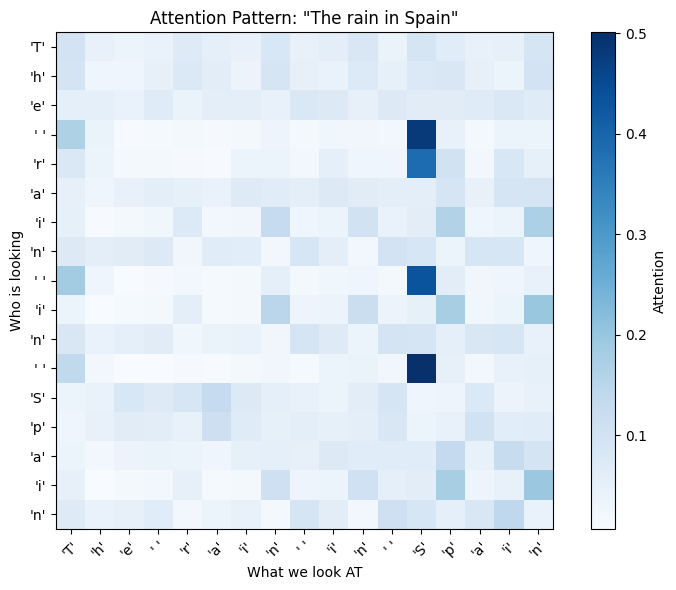

What's happening in 'The rain in Spain':
  ' ' → focuses most on 'S' (0.48)
  'r' → focuses most on 'S' (0.39)
  ' ' → focuses most on 'S' (0.43)
  ' ' → focuses most on 'S' (0.50)


In [24]:
def show_attention(model, tokenizer, text):
    """
    Shows the key insight: how transformers look at previous tokens.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Encode text and get tokens for display
    tokens = torch.tensor(tokenizer.encode(text), dtype=torch.long, device=device).unsqueeze(0)
    token_names = [tokenizer.itos[i] for i in tokenizer.encode(text)]
    
    # Hook to capture attention weights from first layer, first head
    attention_weights = None
    
    def get_attention(module, input, output):
        nonlocal attention_weights
        x = input[0]
        B, T, C = x.size()
        
        # Calculate attention (simplified from the actual module)
        qkv = module.c_attn(x)
        q, k, v = qkv.split(module.n_embd, dim=2)
        q = q.view(B, T, module.n_head, C // module.n_head).transpose(1, 2)
        k = k.view(B, T, module.n_head, C // module.n_head).transpose(1, 2)
        
        att = (q @ k.transpose(-2, -1)) / np.sqrt(k.size(-1))
        if not module.flash:
            att = att.masked_fill(module.bias[:,:,:T,:T] == 0, float('-inf'))
        
        attention_weights = torch.softmax(att, dim=-1)[0, 0].detach().cpu().numpy()
    
    # Capture attention from first layer
    hook = model.transformer.h[0].attn.register_forward_hook(get_attention)
    
    model.eval()
    with torch.no_grad():
        model(tokens)
    hook.remove()
    
    # Simple visualization
    plt.figure(figsize=(8, 6))
    plt.imshow(attention_weights, cmap='Blues')
    plt.xticks(range(len(token_names)), [f"'{t}'" for t in token_names], rotation=45)
    plt.yticks(range(len(token_names)), [f"'{t}'" for t in token_names])
    plt.xlabel('What we look AT')
    plt.ylabel('Who is looking')
    plt.title(f'Attention Pattern: "{text}"')
    plt.colorbar(label='Attention')
    plt.tight_layout()
    plt.show()
    
    # Simple explanation
    print(f"What's happening in '{text}':")
    for i, token in enumerate(token_names):
        # Find what this token pays most attention to
        best_idx = np.argmax(attention_weights[i])
        best_weight = attention_weights[i, best_idx]
        best_token = token_names[best_idx]
        
        if best_weight > 0.2:  # Only show significant attention
            print(f"  '{token}' → focuses most on '{best_token}' ({best_weight:.2f})")

# Test it with a simple example
print("🔍 ATTENTION VISUALIZATION")
print("=" * 40)

# Show attention for one clear example
show_attention(model, tokenizer, "The rain in Spain")